In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
from numpy.linalg import svd, norm, pinv
import scipy.sparse.linalg as sp
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
# import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import codecs
%matplotlib inline

## Load and Munge Data

In [2]:
file_name = 'recipe3.csv'
with open(file_name, "rU") as fdata: # ,encoding='utf-8', errors='ignore') as fdata:
    reader = csv.reader(fdata)
    rawDataList = list(reader)
print("done")

done


In [3]:
rawDataList[0][:15]

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic']

In [4]:
#bring in revised ing list to replace ingListRaw
file_name = 'ingredients5.csv'
with open(file_name, "rU") as fdata: 
    reader = csv.reader(fdata)
    ingListRaw2 = list(reader)[0]
    fdata.close() 
ncol = len(ingListRaw2)
print("done")

done


In [5]:
# Load only data with valid column id (remove bad ingredients like "kosher", "superbowl", etc.)
# into an numpy array
def get_array_epi(rawDataList, ingListRaw2):
    header = rawDataList[0]
    dishNameList = [i[0] for i in rawDataList[1:]]
    ratingsArr = np.array([float(i[1]) for i in rawDataList[1:]])

    dataList = []
    nrow = len(rawDataList) - 1
    for row in rawDataList[1:nrow+1]:
        newArr = np.zeros(ncol)
        ct_valid_ing = 0
        for ct_all, j in enumerate(row): # returns index and item ct_all = index
            if header[ct_all] in ingListRaw2:
                try:
                    newArr[ct_valid_ing] = float(j)
                except(ValueError):
                    newArr[ct_valid_ing] = 0.0
                ct_valid_ing += 1
        dataList.append(newArr)
    Araw = np.array(dataList)
    return Araw

Araw = get_array_epi(rawDataList, ingListRaw2)
print ('done')

done


In [6]:
print len(rawDataList)

20053


In [7]:
def convert_array_to_json(Araw, ingListRaw2):
    newList = []
    recID_val = 49717  # max id 1st data set = 49,717

    for row in Araw:
        ingList = []
        newDict = {'cuisine': 'epicurious'} 
        recID_val = recID_val+1
        newDict['id'] = recID_val
        colidx= 0
        for item in row:
            if np.abs(item - 1.0) < 0.00001:   # if item =1 store in array
                ingList.append(ingListRaw2[colidx])
            colidx += 1
        newDict['ingredients'] = ingList
        newList.append(newDict)
    return newList

newList = convert_array_to_json(Araw, ingListRaw2)
print len(newList)
print newList[0:2]

20052
[{'cuisine': 'epicurious', 'id': 49718, 'ingredients': ['apples', 'beans', 'cookie', 'fruit', 'lemongrass', 'lentils', 'tomatillos', 'veal', 'turkey']}, {'cuisine': 'epicurious', 'id': 49719, 'ingredients': ['bastille day', 'chill', 'dried fruit', 'olives', 'poppy seeds', 'pork tenderloin']}]


In [8]:
# import pickle

# file_out = open('epi_dataList.pck', 'wb')
# pickle.dump(newList, file_out)
# file_out.close()
# print 'done'

done


In [8]:
ct=-1
for ing in rawDataList[0]:
    ct +=1
    if ing == 'jerusalem artichokes':
        print ct, rawDataList[0][ct]

301 jerusalem artichokes


In [9]:
# list recipies that have a specific ingredient
for row in rawDataList:
    if row[301] =='1':
        print row[0]
    

Purթe of Three Root Vegetables 
Crispy Artichoke Flowers with Salsa Verde 
Filets Mignons on Jerusalem Artichoke Purթe 
Roast Chicken with Parsnips, Golden Beets, and Jerusalem Artichokes with Beer Pan Juices 
Soup Doria 
Jerusalem Artichoke Soup with Pumpernickel Croutons 
Brioche Crusted fish with Jerusalem Artichoke Puree and Jerusalem Artichoke Pickles 
Yukon Gold Potato and Jerusalem Artichoke Latkes with Apple-Horseradish Mayonnaise and Taramasalata 
Jerusalem Artichoke Chips with Lemon Thyme Dip 
Jerusalem Artichoke and Sage Gratin 
Cream of Jerusalem Artichoke Soup 
Filets Mignons on Jerusalem Artichoke Purթe 
Jerusalem Artichoke and Artichoke Heart Linguine 
Tamarind-Braised Short Ribs with Truffle Sunchoke Purթe, Watercress Purթe, and Glazed Chanterelle Mushrooms 
Cream of Jerusalem Artichoke and Celery Soup 
Jerusalem Artichoke and Lima Bean Sautթ 
Celery Root and Potato Puree with Roasted Jerusalem Artichoke "Croutons" 
Jerusalem Artichoke Pickles 
Hanger Steak with Shallot

# Normalize and Filter Data

402
(20052L, 377L)


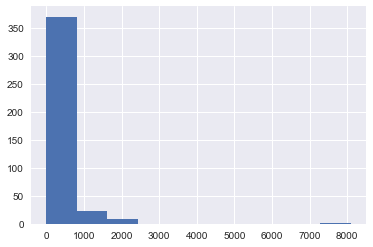

In [10]:
print(len(ingListRaw2))
ingFreqArr = np.sum(Araw, axis = 0)
plt.hist(ingFreqArr)
    
min_rec_cut = 4 # 3
max_rec_cut = 20000 # 800
valid_ing_ids = (ingFreqArr>=min_rec_cut) & (ingFreqArr <= max_rec_cut) #only appear in this range
A1 = Araw[:, valid_ing_ids]  #boolean list
print(A1.shape)

# remove extremely rare ingredients   move to spark?
ingList = []
for idx in range(len(ingListRaw2)):
    if valid_ing_ids[idx] == 1:
        ingList.append(ingListRaw2[idx])


# Nonnegative Matrix Factorization (NMF)
## Dimensionality Reduction & Prototype Discovery

In [11]:
num_prototypes = 40
nmf = NMF(n_components=num_prototypes, init=None, solver='cd', tol=0.0001, max_iter=3000)
Wraw = nmf.fit_transform(A1)
Hraw = nmf.components_
print('done')

done


In [12]:
H = (Hraw.T/np.sum(Hraw.T, axis = 0)).T
hDict = {}
num_words_per_proto = 8
for proto_idx in range(num_prototypes):
    hDict[proto_idx] = []
    h = H[proto_idx, :]
    ids = np.argsort(h)[::-1]
    for idx in ids[:num_words_per_proto]:
        hDict[proto_idx].append([ingList[idx], h[idx]])
#         print ingList[idx], h[idx]

Z = A1.dot(H[:num_prototypes, :].T)
print('done')

done


In [13]:
print( hDict[6])

[['garlic', 0.73004270345854683], ['root vegetables', 0.027596473852581082], ['parmesan cheese', 0.023952321764517052], ['kumquats', 0.023018462193792888], ['beans', 0.020604981819236319], ['tequila', 0.016002092315086581], ['orange juice', 0.013036527815964752], ['hot pepper', 0.0095137450698960565]]


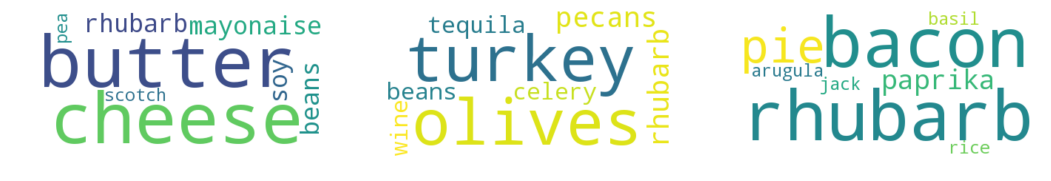

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (18, 24))
for plt_ct, idx in enumerate([0, 1, 38]):
    text = ' '
    for ct, row in enumerate(hDict[idx][::-1]):
            raw_word = row[0]
            if ' ' in  raw_word:
                word = raw_word.split(' ')[1]
            else:
                word = raw_word
            text += word + ' '

    wc = WordCloud(background_color="white")
    wc.generate(text)
    # wc.to_file('%s.png' % proto_name)
    ax[plt_ct].imshow(wc, interpolation='bilinear')
    ax[plt_ct].axis("off")


# Clustering

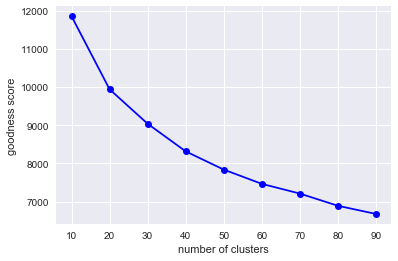

In [15]:
kList = np.arange(10, 100, 10)
lossList = []
for k in kList:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                           max_iter=5000, precompute_distances=True,)

    kmeans.fit(Z)
    lbls = kmeans.labels_
    loss = kmeans.inertia_
    lossList.append(loss)
plt.plot(kList, lossList, 'b-o')
plt.xlabel('number of clusters')
plt.ylabel('goodness score')

In [16]:
k = 25   # number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, 
                           max_iter=1000, precompute_distances=True,)
kmeans.fit(Z)
lblArr = kmeans.labels_

dishNameList = [i[0] for i in rawDataList[1:]]
lblList = list(lblArr)


In [17]:
lblList[0:5]  # 1st recipe in cluster 21

[0, 9, 23, 3, 23]

In [18]:
ct = 0
for i in range(1000):            #nrow):
    if lblList[i] == 2 and ct < 20:  # 1st 20 recipes in cluster 2
        print(dishNameList[i])
        ct += 1

White Chocolate Tartlets with Strawberries and Bananas 
Banana Layer Cake with Cream Cheese Frosting 
Stout Floats 
Potato Gratin with Goat Cheese and Garlic 
Roasted Beets and Citrus with Feta 
Dark Chocolate Wedding Cake with Chocolate Orange Ganache and Orange Buttercream 
Cassata Cake 
Butternut Squash-Parsnip Soup with Thyme 
Honey-Cinnamon Ice Cream 
Apple Treacle Tart 
Avocado and Smoked Pork Carnitas 
Old-Fashioned Indian Pudding 
Lemon-Ginger Frozen Yogurt 
Toasted Almond Cream Pie with Boysenberry Topping 
Banana Rum Puffs 
Orange-Vanilla Sundaes with Dates and Orange Muscat 
Ginger-Cream Cheese Icing 
Ashkenazic Sour Cream Coffee Cake (Smeteneh K�_chen) 
Orange Rice Pudding 
Sour Cream Layer Cake with Pecan Brittle 


5


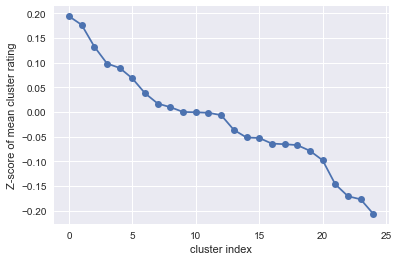

In [19]:
# ratings of clusters
ans = list()
ratDict = {}
ratingsArr = np.array([float(i[1]) for i in rawDataList[1:]])
ratingsArrFilt = ratingsArr[ratingsArr > 1.0]
mean_rat = np.mean(ratingsArrFilt)
for i in range(k):
    ratArrRaw = ratingsArr[lblArr == i]
    ratArr = ratArrRaw[ratArrRaw > 1.0]
    ans.append([(np.mean(ratArr) - mean_rat)/np.std(ratingsArrFilt), len(ratArr), i])
    ratDict[i] = (ratArr - mean_rat)/np.std(ratingsArrFilt)
ans.sort(key = lambda x: x[0], reverse = True)
ansArr = np.array([i[0] for i in ans]) 
nArr = np.array([i[1] for i in ans])
idxArr = np.array([i[2] for i in ans])  
print(idxArr[0])
plt.plot(ansArr, '-o')
plt.ylabel('Z-score of mean cluster rating')
plt.xlabel('cluster index')